# <span style="color:blue"> Esercitazione 3 - Pricing di opzioni europee con calcolo Monte Carlo </span>

## <span style="color:blue"> Indice</span>

- [Esercizio 3.1 - Calcolo del prezzo di un'opzione europea con metodo Monte Carlo](#Esercizio3.1)

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from numpy.lib.scimath import log, sqrt
from numpy import exp

## <span id="Esercizio3.1" style="color:blue">  Esercizio 3.1 - Calcolo del prezzo di un'opzione europea con metodo Monte Carlo </span>[^](#toc)

### 0. Generalità

#### Il problema

In questo esercizio è stato determinato il prezzo di un'opzione europea _call_ e di una _put_ attraverso calcoli Monte Carlo.

Di seguito si riportano i parametri del calcolo:
- tempo della stipulazione del contratto: $t_0=0$
- tempo della scadenza del contratto (_expiry date_ o _delivery time_): $T=1$
- prezzo dell'asset (_underlying_) al tempo $t_0$: $S(t_0)=S(0)=100$
- prezzo dell'asset concordato al tempo $T$ (_strike price_): $K=100$
- tasso di interesse risk-free: $r=0.1$
- volatilità dell'underlying sul mercato: $\sigma=0.25$

Assumendo che l'andamento $S(t)$ del prezzo dell'underlying sia ben descritto da un moto browniano geometrico con i parametri appena elencati ($S\sim GBM(r,\sigma^2)$), si ha che
$$S(t) = S(t_0) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)(t-t_0)+\sigma (W(t)-W(t_0))\right]$$
dove $W(t)-W(t_0)\sim \mathcal{N}(0,t-t_0)$ rappresenta l'incremento da $t_0$ e $t$ di un processo di Wiener (moto browniano standard). Partendo da $t_0=0$, si può semplificare: $$S(t) = S(0) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$
con $W(t)\sim\mathcal{N}(0,t)$.

Partendo da ciò, il prezzo "corretto" di un'opzione europea associata a questo asset da attribuire al tempo $t_0=0$ è dato da
- per un opzione _call_: $C\left[S(0),0\right]=e^{-rT}\mathbb{E}\left[\mathrm{max}\left(S(T)-K,0\right)\right]$
- per un opzione _put_: $P\left[S(0),0\right]=e^{-rT}\mathbb{E}\left[\mathrm{max}\left(K-S(T),0\right)\right]$

ovvero il valore di aspettazione del massimo tra $0$ la differenza tra spot price dell'asset all'expiry e strike price, scontato per il fattore $e^{-rT}$. Se questo fattore non ci fosse, sarebbe più conveniente per l'holder depositare i soldi in banca anziché sottoscrivere l'opzione.

Questo calcolo è eseguibile con metodi Monte Carlo: si simula un gran numero di traiettorie (andamenti) dello spot price $S(t)$ da $t_0$ a $T$, e per ognuna di esse si calcola $e^{-rT}\mathrm{max}\left(S(T)-K,0\right)$ o $e^{-rT}\mathrm{max}\left(K-S(T),0\right)$. Mediando opportunamente i valori ottenuti, si ottiene il valore di aspettazione, e quindi il prezzo dell'opzione. 

#### La soluzione analitica

È possibile confrontare i risultati con la soluzione analitica del problema, ottenuta da Black e Scholes. Ad un tempo $t<T$, il prezzo "corretto" delle opzioni è dato da
- Call option: $$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- Put option: $$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$
con
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2}  \right)(T-t)\right]$$

dove $d_2 = d_1 - \sigma\sqrt{T-t}$, e dove $N(x)$ è la cumulativa della gaussiana standardizzata:
$$ N(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
con
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

In [227]:
# data
S0=100.
K=100.
T=1.
r=0.1
sigma=0.25
t=0

def N(x):
    return 0.5*(1.+erf(x/sqrt(2.)))

def black_scholes(S0,K,T,r,sigma):
    d1=1./(sigma*sqrt(T))*(log(S0/K)+(r+(sigma**2)/2.)*T)
    d2=d1-sigma*sqrt(T)
    C=S0*N(d1)-K*exp(-r*T)*N(d2)
    P=S0*(N(d1)-1.)-K*exp(-r*T)*(N(d2)-1.)
    return C,P
call,put = black_scholes(S0, K, T, r, sigma)
print("Risultati attesi:")
print("Call option:",np.round(call,3))
print("Put option:",np.round(put,3))

Risultati attesi:
Call option: 14.976
Put option: 5.46


### i. Pricing attraverso campionamento diretto del prezzo finale

#### Descrizione

Il modo più immediato per calcolare $C\left[S(0),0\right]$ e $P\left[S(0),0\right]$ è eseguire il campionamento diretto della variabile $S(T)$, ovvero il prezzo dell'underlying al delivery time $T$, applicando direttamente
$$S(T) = S(0) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)T+\sigma W(T)\right]$$
Per farlo, si sfrutta il fatto che gli incrementi di $W$ sono statisticamente indipendenti tra loro (purché calcolati tra intervalli di tempo disgiunti) e tali che $W(t)\sim\mathcal{N}(0,t)$. È infatti possibile generare una sequenza di pseudo-casuali che simula diverse realizzazioni della variabile stocastica $W(T)$ campionando una gaussiana con media nulla e varianza $T$.

La procedura implementata è la seguente:
- si simula il prezzo $S(T)$, usando la tecnica appena descritta, un numero $M$ molto grande di volte, e ognuna di queste volte si calcolano
$$e^{-rT}\mathrm{max}(S(T)-K,0)\quad \mathrm{ed} \quad e^{-rT}\mathrm{max}(K-S(T),0)$$
- dopo aver suddiviso i dati in $N$ blocchi sufficientemente lunghi, si calcolano le block averages
$$ C_i=\frac{1}{L}\sum_{j=(i-1)L+1}^{i L}{e^{-rT}\mathrm{max}(S_j(T)-K,0)} \quad \mathrm{e} \quad P_i=\frac{1}{L}\sum_{j=(i-1)L+1}^{i L}{e^{-rT}\mathrm{max}(K-S_j(T),0)}$$
  con $i=1,...,N$ indice di blocco e $L=M/N$ lunghezza di ciascun blocco. L’operazione di media fornisce una stima del valore di aspettazione all’interno dell’i-esimo blocco.
- in accordo con quanto descritto nella discussione dell'_Esercizio 1.1_ riguardo la media a blocchi, i valori medi progressivi e le relative incertezze statistiche progressive sono dati da
$$C\left[S(0),0\right]_n=<C>_n=\frac{1}{n}\sum_{i=1}^n{C_i}\quad \mathrm{e} \quad \sigma_{<C>_n}=\sqrt{\frac{<C^2>_n-<C>_n^2}{n-1}}$$
  e
$$P\left[S(0),0\right]_n=<P>_n=\frac{1}{n}\sum_{i=1}^n{P_i}\quad \mathrm{e} \quad \sigma_{<P>_n}=\sqrt{\frac{<P^2>_n-<P>_n^2}{n-1}}$$
  dove $n=1,...,N$ è il numero di blocchi considerati nella media, partendo dal primo.
- valor medio e incertezza finali delle due opzioni sono dati da $C\left[S(0),0\right]=<C>_N$ e $\sigma_{<C>}=\sigma_{<C>_N}$, e $P\left[S(0),0\right]=<P>_N$ e $\sigma_{<P>}=\sigma_{<P>_N}$.

#### Calcolo e risultati

Il calcolo è stato svolto con $M=10^6$ campionamenti e $N=10^3$ blocchi, ovvero $10^3$ stime di $C\left[S(0),0\right]$ e $P\left[S(0),0\right]$. Ogni blocco è lungo $L=M/N=10^3$.

Di seguito è mostrato l'andamento della media progressiva $<C>_n$ in funzione del numero di blocchi $n$, con barre di errore date dalle $\sigma_{<C>_n}$ ($\sigma_{<C>_1}=0$).

In [262]:
# Load the data (direct sampling)
# Notation: "Cdir"=value of C obtained with direct sampling, "Pdir"=value of P obtained with direct sampling
Path="../Es03_01/Output/results_direct.dat"
(
    BlockNumber,                # Block indexes (1-N)
    CdirMeanValueProg,          # Progressive averages <C>: CdirMeanValueProg[i]=<C> estimated over the first (i+1) blocks
    CdirStDevOfTheMeanProg,     # Progressive statistical uncertainty of <C>: CdirStDevOfTheMeanProg[i]=uncertainty of CdirMeanValueProg[i]
    PdirMeanValueProg,          # Progressive averages <P>: PdirMeanValueProg[i]=<P> estimated over the first (i+1) blocks
    PdirStDevOfTheMeanProg      # Progressive statistical uncertainty of <P>: PdirStDevOfTheMeanProg[i]=uncertainty of PdirMeanValueProg[i]
)=np.loadtxt(Path,usecols=(0,1,2,3,4),unpack=True)

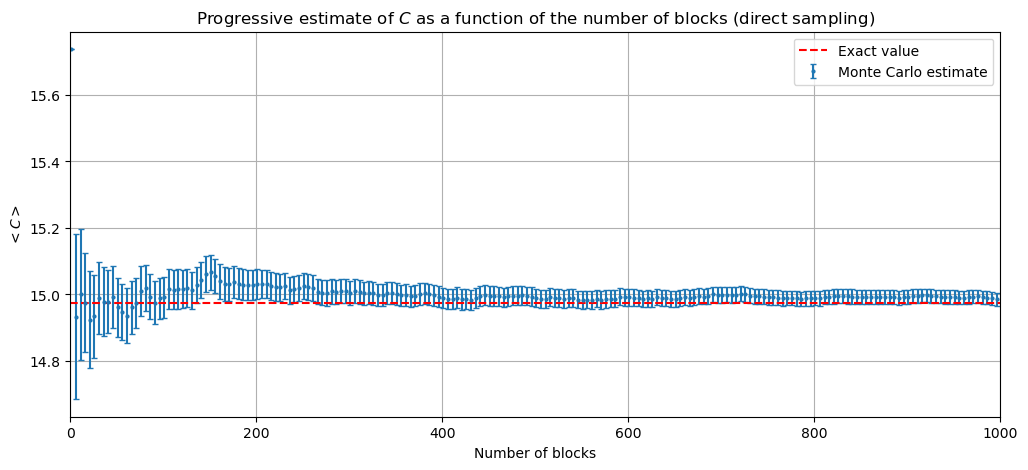

In [357]:
# Plot the progressive average
k=5  # plot one point every k blocks
plt.figure(figsize=(12,5))
plt.errorbar(BlockNumber[::k],CdirMeanValueProg[::k],yerr=CdirStDevOfTheMeanProg[::k],fmt='.',markersize=4,capsize=2,label='Monte Carlo estimate')
plt.axhline(call,color='r',linestyle='--',label='Exact value')
plt.title('Progressive estimate of $C$ as a function of the number of blocks (direct sampling)')
plt.xlabel('Number of blocks')
plt.ylabel(r'$<C>$')
plt.xlim(0,BlockNumber[-1])
plt.ylim()
plt.legend()
plt.grid(True)
plt.show()

Dal grafico si osserva che
- la stima progressiva di $⟨C⟩$ converge verso il valore atteso $14.976$, con fluttuazioni sempre minori attorno ad esso, al crescere del numero di blocchi
- l'incertezza statistica sulla media
    - diminuisce al crescere del numero di blocchi
    - dopo un certo numero di blocchi segue un andamento regolare (raggiunge il regime asintotico). In questo regime la stima dell’errore statistico è affidabile.

Per maggiori dettagli sull'andamento dell'errore statistico quando si esegue la media a blocchi, e il suo legame con il teorema del limite centrale, si rimanda al paragrafo _Digressione sul teorema del limite centrale_ dell'_Esercizio 1.1_ del notebook dell'_Esercitazione 1_.

Il risultato del calcolo è:

In [291]:
print(f"<C>={CdirMeanValueProg[-1]:.3f}±{CdirStDevOfTheMeanProg[-1]:.3f}")
print(f"C_exp={call:.3f}")

<C>=14.985±0.020
C_exp=14.976


che risulta pienamente compatibile con il valore teorico, essendo la deviazione pari a

In [368]:
z=np.abs(CdirMeanValueProg[-1]-call)/CdirStDevOfTheMeanProg[-1]
print(f"z={np.round(z,2)}")

z=0.48


ben inferiore a $1\sigma$. Il calcolo risulta quindi corretto.

Di seguito è mostrato l'andamento della media progressiva $<P>_n$ in funzione del numero di blocchi $n$, con barre di errore date dalle $\sigma_{<P>_n}$ ($\sigma_{<P>_1}=0$).

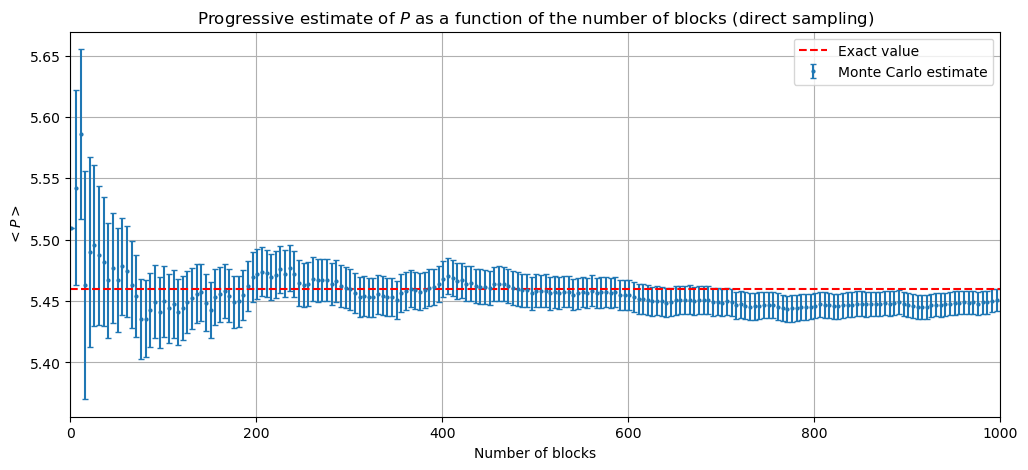

In [302]:
# Plot the progressive average
k=5  # plot one point every k blocks
plt.figure(figsize=(12,5))
plt.errorbar(BlockNumber[::k],PdirMeanValueProg[::k],yerr=PdirStDevOfTheMeanProg[::k],fmt='.',markersize=4,capsize=2,label='Monte Carlo estimate')
plt.axhline(put,color='r',linestyle='--',label='Exact value')
plt.title('Progressive estimate of $P$ as a function of the number of blocks (direct sampling)')
plt.xlabel('Number of blocks')
plt.ylabel(r'$<P>$')
plt.xlim(0,BlockNumber[-1])
plt.ylim()
plt.legend()
plt.grid(True)
plt.show()

Si possono fare le stesse osservazioni fatte per il caso dell'opzione call. Il risultato del calcolo è:

In [310]:
print(f"<P>={PdirMeanValueProg[-1]:.3f}±{PdirStDevOfTheMeanProg[-1]:.3f}")
print(f"P_exp={put:.3f}")

<P>=5.451±0.009
P_exp=5.460


Esso è compatibile statisticamente con il valore atteso entro $1\sigma$, confermando la correttezza del calcolo Monte Carlo.

In [350]:
z=np.abs(PdirMeanValueProg[-1]-put)/PdirStDevOfTheMeanProg[-1]
print(f"z={np.round(z,2)}")

z=0.91


### ii. Pricing tramite simulazione discretizzata del processo stocastico

#### Descrizione

È possibile ottenere il medesimo risultato simulando la traiettoria $S(t)$ nel tempo.

Scelti gli istanti di campionamento $\{t_i\}_{i_0}^{N_{steps}}$, tali che $t_i<t_{i+1} \forall i$ e con $t_{N_{steps}}=T$, tra due qualsiasi istanti successivi vale sempre la formula precedente:
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)+\sigma (W(t_{i+1})-W(t_i))\right]$$
con $W(t_{i+1})-W(t_i) \sim\mathcal{N}(0,t_{i+1}-t_i)$, $\forall i=0,\dots,N_{steps}$.

È sufficiente dunque suddividere l'intervallo temporale $[t_0,T]$ in $N_{steps}$ sotto-intervalli identici e, partendo da $S(t_0)$ e applicando ricorsivamente la formula, si ottiene $S(T)$. In questo modo, però, si campiona la traiettoria del prezzo dell'underlying ad intervalli discreti. Poiché ad ogni intervallo si utilizza la soluzione esatta del moto browniano geometrico, la distribuzione finale di $S(T)$ coincide con quella ottenuta nel campionamento diretto.

In questa fase dell'esercizio, è stato implementato questo calcolo all'interno della simulazione, e sono stati calcolati i prezzi dei due tipi di opzione seguendo lo stesso procedimento descritto in precedenza.

#### Calcolo e risultati

- Il calcolo è stato svolto con $M=10^6$ campionamenti e $N=10^3$ blocchi. Ogni blocco è lungo $L=M/N=10^3$.
- L'andamento di $S(t)$ è stato campionato $N_{steps}=100$ volte in $(0,T]$.
- Le block average $C_i$ e $P_i$ sono state calcolate a partire dai valori di $S(T)$ ottenuti al termine della simulazione della traiettoria discretizzata con $N_{steps}$ passi temporali.

Di seguito è mostrato l'andamento della media progressiva $<C>_n$ in funzione del numero di blocchi $n$, con barre di errore date dalle $\sigma_{<C>_n}$ ($\sigma_{<C>_1}=0$).

In [359]:
# Load the data (discrete sampling)
# Notation: "Cdis"=value of C obtained with discrete sampling, "Pdis"=value of P obtained with discrete sampling
Path="../Es03_01/Output/results_discrete.dat"
(
    BlockNumber,                # Block indexes (1-N)
    CdisMeanValueProg,          # Progressive averages <C>: CdisMeanValueProg[i]=<C> estimated over the first (i+1) blocks
    CdisStDevOfTheMeanProg,     # Progressive statistical uncertainty of <C>: CdisStDevOfTheMeanProg[i]=uncertainty of CdisMeanValueProg[i]
    PdisMeanValueProg,          # Progressive averages <P>: PdisMeanValueProg[i]=<P> estimated over the first (i+1) blocks
    PdisStDevOfTheMeanProg      # Progressive statistical uncertainty of <P>: PdisStDevOfTheMeanProg[i]=uncertainty of PdisMeanValueProg[i]
)=np.loadtxt(Path,usecols=(0,1,2,3,4),unpack=True)

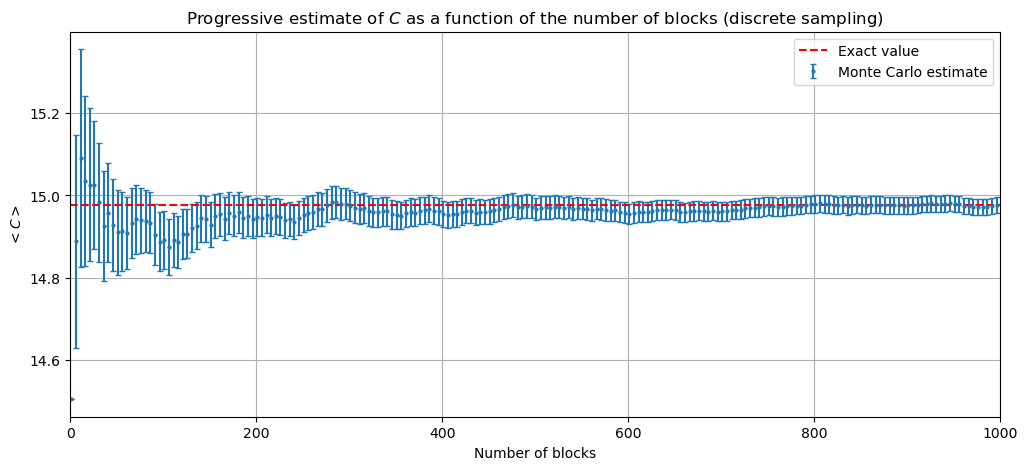

In [361]:
# Plot the progressive average
k=5  # plot one point every k blocks
plt.figure(figsize=(12,5))
plt.errorbar(BlockNumber[::k],CdisMeanValueProg[::k],yerr=CdisStDevOfTheMeanProg[::k],fmt='.',markersize=4,capsize=2,label='Monte Carlo estimate')
plt.axhline(call,color='r',linestyle='--',label='Exact value')
plt.title('Progressive estimate of $C$ as a function of the number of blocks (discrete sampling)')
plt.xlabel('Number of blocks')
plt.ylabel(r'$<C>$')
plt.xlim(0,BlockNumber[-1])
plt.ylim()
plt.legend()
plt.grid(True)
plt.show()

Anche in questo caso, gli andamenti del valor medio e dell'incertezza statistica progressivi sono in accordo con il loro comportamento atteso.
Il risultato del calcolo è:

In [365]:
print(f"<C>={CdisMeanValueProg[-1]:.3f}±{CdisStDevOfTheMeanProg[-1]:.3f}")
print(f"C_exp={call:.3f}")

<C>=14.974±0.019
C_exp=14.976


Il risultato è pienamente compatibile con il valore analitico di Black–Scholes. Lo scarto è pari a

In [372]:
z=np.abs(CdisMeanValueProg[-1]-call)/CdisStDevOfTheMeanProg[-1]
print(f"z={np.round(z,2)}")

z=0.09


quindi largamente entro $1\sigma$.

Di seguito è mostrato l'andamento della media progressiva $<P>_n$ in funzione del numero di blocchi $n$, con barre di errore date dalle $\sigma_{<P>_n}$ ($\sigma_{<P>_1}=0$).

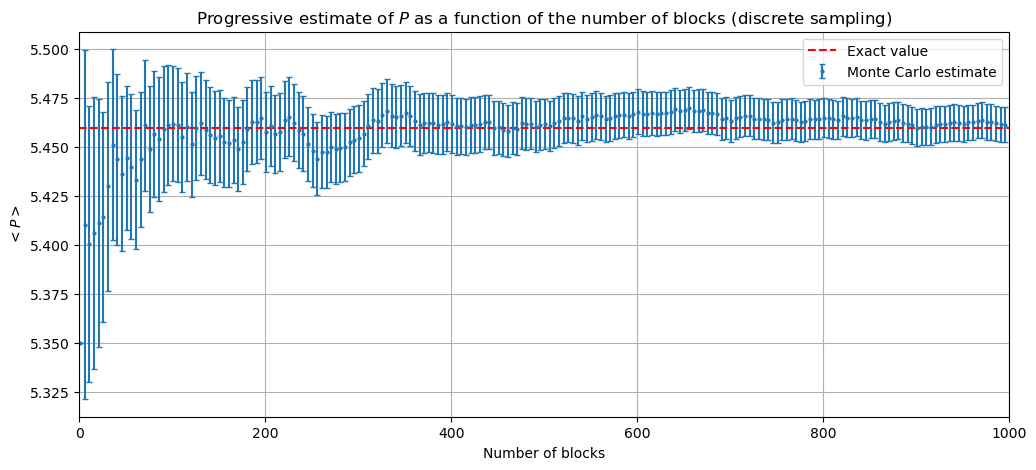

In [380]:
# Plot the progressive average
k=5  # plot one point every k blocks
plt.figure(figsize=(12,5))
plt.errorbar(BlockNumber[::k],PdisMeanValueProg[::k],yerr=PdisStDevOfTheMeanProg[::k],fmt='.',markersize=4,capsize=2,label='Monte Carlo estimate')
plt.axhline(put,color='r',linestyle='--',label='Exact value')
plt.title('Progressive estimate of $P$ as a function of the number of blocks (discrete sampling)')
plt.xlabel('Number of blocks')
plt.ylabel(r'$<P>$')
plt.xlim(0,BlockNumber[-1])
plt.ylim()
plt.legend()
plt.grid(True)
plt.show()

Anche in questo caso, gli andamenti del valor medio e dell'incertezza statistica progressivi sono in accordo con il loro comportamento atteso.
Il risultato del calcolo è:

In [387]:
print(f"<P>={PdisMeanValueProg[-1]:.3f}±{PdisStDevOfTheMeanProg[-1]:.3f}")
print(f"P_exp={put:.3f}")
z=np.abs(PdisMeanValueProg[-1]-put)/PdisStDevOfTheMeanProg[-1]
print(f"z={np.round(z,2)}")

<P>=5.461±0.009
P_exp=5.460
z=0.19


Anche in questo caso il risultato è pienamente compatibile con la soluzione analitica di Black–Scholes, confermando la correttezza del calcolo Monte Carlo.

### iii. Confronto

Confrontando i valori finali di $<C>$ e $<P>$ ottenuti con i due metodi (campionamento diretto di $S(T)$ e simulazione discretizzata della traiettoria $S(t)$), si osserva che essi risultano tra loro compatibili statisticamente entro le rispettive incertezze. Entrambi sono inoltre compatibili con il valore analitico fornito dalla formula di Black–Scholes.

Questo costituisce una verifica della correttezza dell’implementazione: i due metodi, pur essendo concettualmente diversi (uno campiona direttamente la distribuzione finale, l’altro ricostruisce la traiettoria passo dopo passo), descrivono lo stesso processo stocastico e devono quindi condurre allo stesso valore atteso per il prezzo dell’opzione.

Si nota che, in questa specifica simulazione, i risultati ottenuti con il metodo discretizzato risultano più vicini al valore analitico.

In [418]:
print(f"<C>_direct  ={CdirMeanValueProg[-1]:.3f}±{CdirStDevOfTheMeanProg[-1]:.3f}")
print(f"<C>_discrete={CdisMeanValueProg[-1]:.3f}±{CdisStDevOfTheMeanProg[-1]:.3f}")
print(f"<C>_expected={call:.3f}")
print(f"<P>_direct  = {PdirMeanValueProg[-1]:.3f}±{PdirStDevOfTheMeanProg[-1]:.3f}")
print(f"<P>_discrete= {PdisMeanValueProg[-1]:.3f}±{PdisStDevOfTheMeanProg[-1]:.3f}")
print(f"<P>_expected= {put:.3f}")

<C>_direct  =14.985±0.020
<C>_discrete=14.974±0.019
<C>_expected=14.976
<P>_direct  = 5.451±0.009
<P>_discrete= 5.461±0.009
<P>_expected= 5.460
